In [1]:
%matplotlib inline 

import numpy as np 
import torch 
import os 

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [6]:
w = torch.ones(())
b = torch.zeros(())

w, w.shape, b, b.shape

(tensor(1.), torch.Size([]), tensor(0.), torch.Size([]))

In [7]:
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [8]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [9]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)

print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [10]:
delta = 0.1 

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - 
                        loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

lr = 1e-2

w = w - lr * loss_rate_of_change_w

In [11]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - 
                        loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - lr * loss_rate_of_change_b

In [19]:
def dloss_fn(t_p, t_c):
    diff = 2 * (t_p - t_c) / t_p.size(0)
    return diff

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_tp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_tp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_tp * dmodel_db(t_u, w, b)

    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [20]:
gradient = grad_fn(t_u, t_c, t_p, w, b)
gradient, gradient.shape

(tensor([4517.2969,   82.6000]), torch.Size([2]))

In [41]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        w, b = params 

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad 
        if epoch in {1, 2, 3, 10, 80, 90, n_epochs - 1, n_epochs}:
            print('Epoch {:3d}, Loss {:3f}'.format(epoch, float(loss)))
            print('\tParams: ', params)
            print('\tGrad:',grad)
        elif epoch in {4, 50, 4000}:
            print('...')
        
    return params

In [42]:
t_un = 0.1 * t_u
params = training_loop(n_epochs=5000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_un, t_c=t_c)

Epoch   1, Loss 80.364342
	Params:  tensor([1.7761, 0.1064])
	Grad: tensor([-77.6140, -10.6400])
Epoch   2, Loss 37.574917
	Params:  tensor([2.0848, 0.1303])
	Grad: tensor([-30.8623,  -2.3864])
Epoch   3, Loss 30.871077
	Params:  tensor([2.2094, 0.1217])
	Grad: tensor([-12.4631,   0.8587])
...
Epoch  10, Loss 29.030487
	Params:  tensor([ 2.3232, -0.0710])
	Grad: tensor([-0.5355,  2.9295])
...
Epoch  80, Loss 23.501379
	Params:  tensor([ 2.6649, -2.0047])
	Grad: tensor([-0.4599,  2.6035])
Epoch  90, Loss 22.813547
	Params:  tensor([ 2.7105, -2.2626])
	Grad: tensor([-0.4522,  2.5597])
...
Epoch 4999, Loss 2.927647
	Params:  tensor([  5.3671, -17.3012])
	Grad: tensor([-0.0001,  0.0006])
Epoch 5000, Loss 2.927648
	Params:  tensor([  5.3671, -17.3012])
	Grad: tensor([-0.0001,  0.0006])


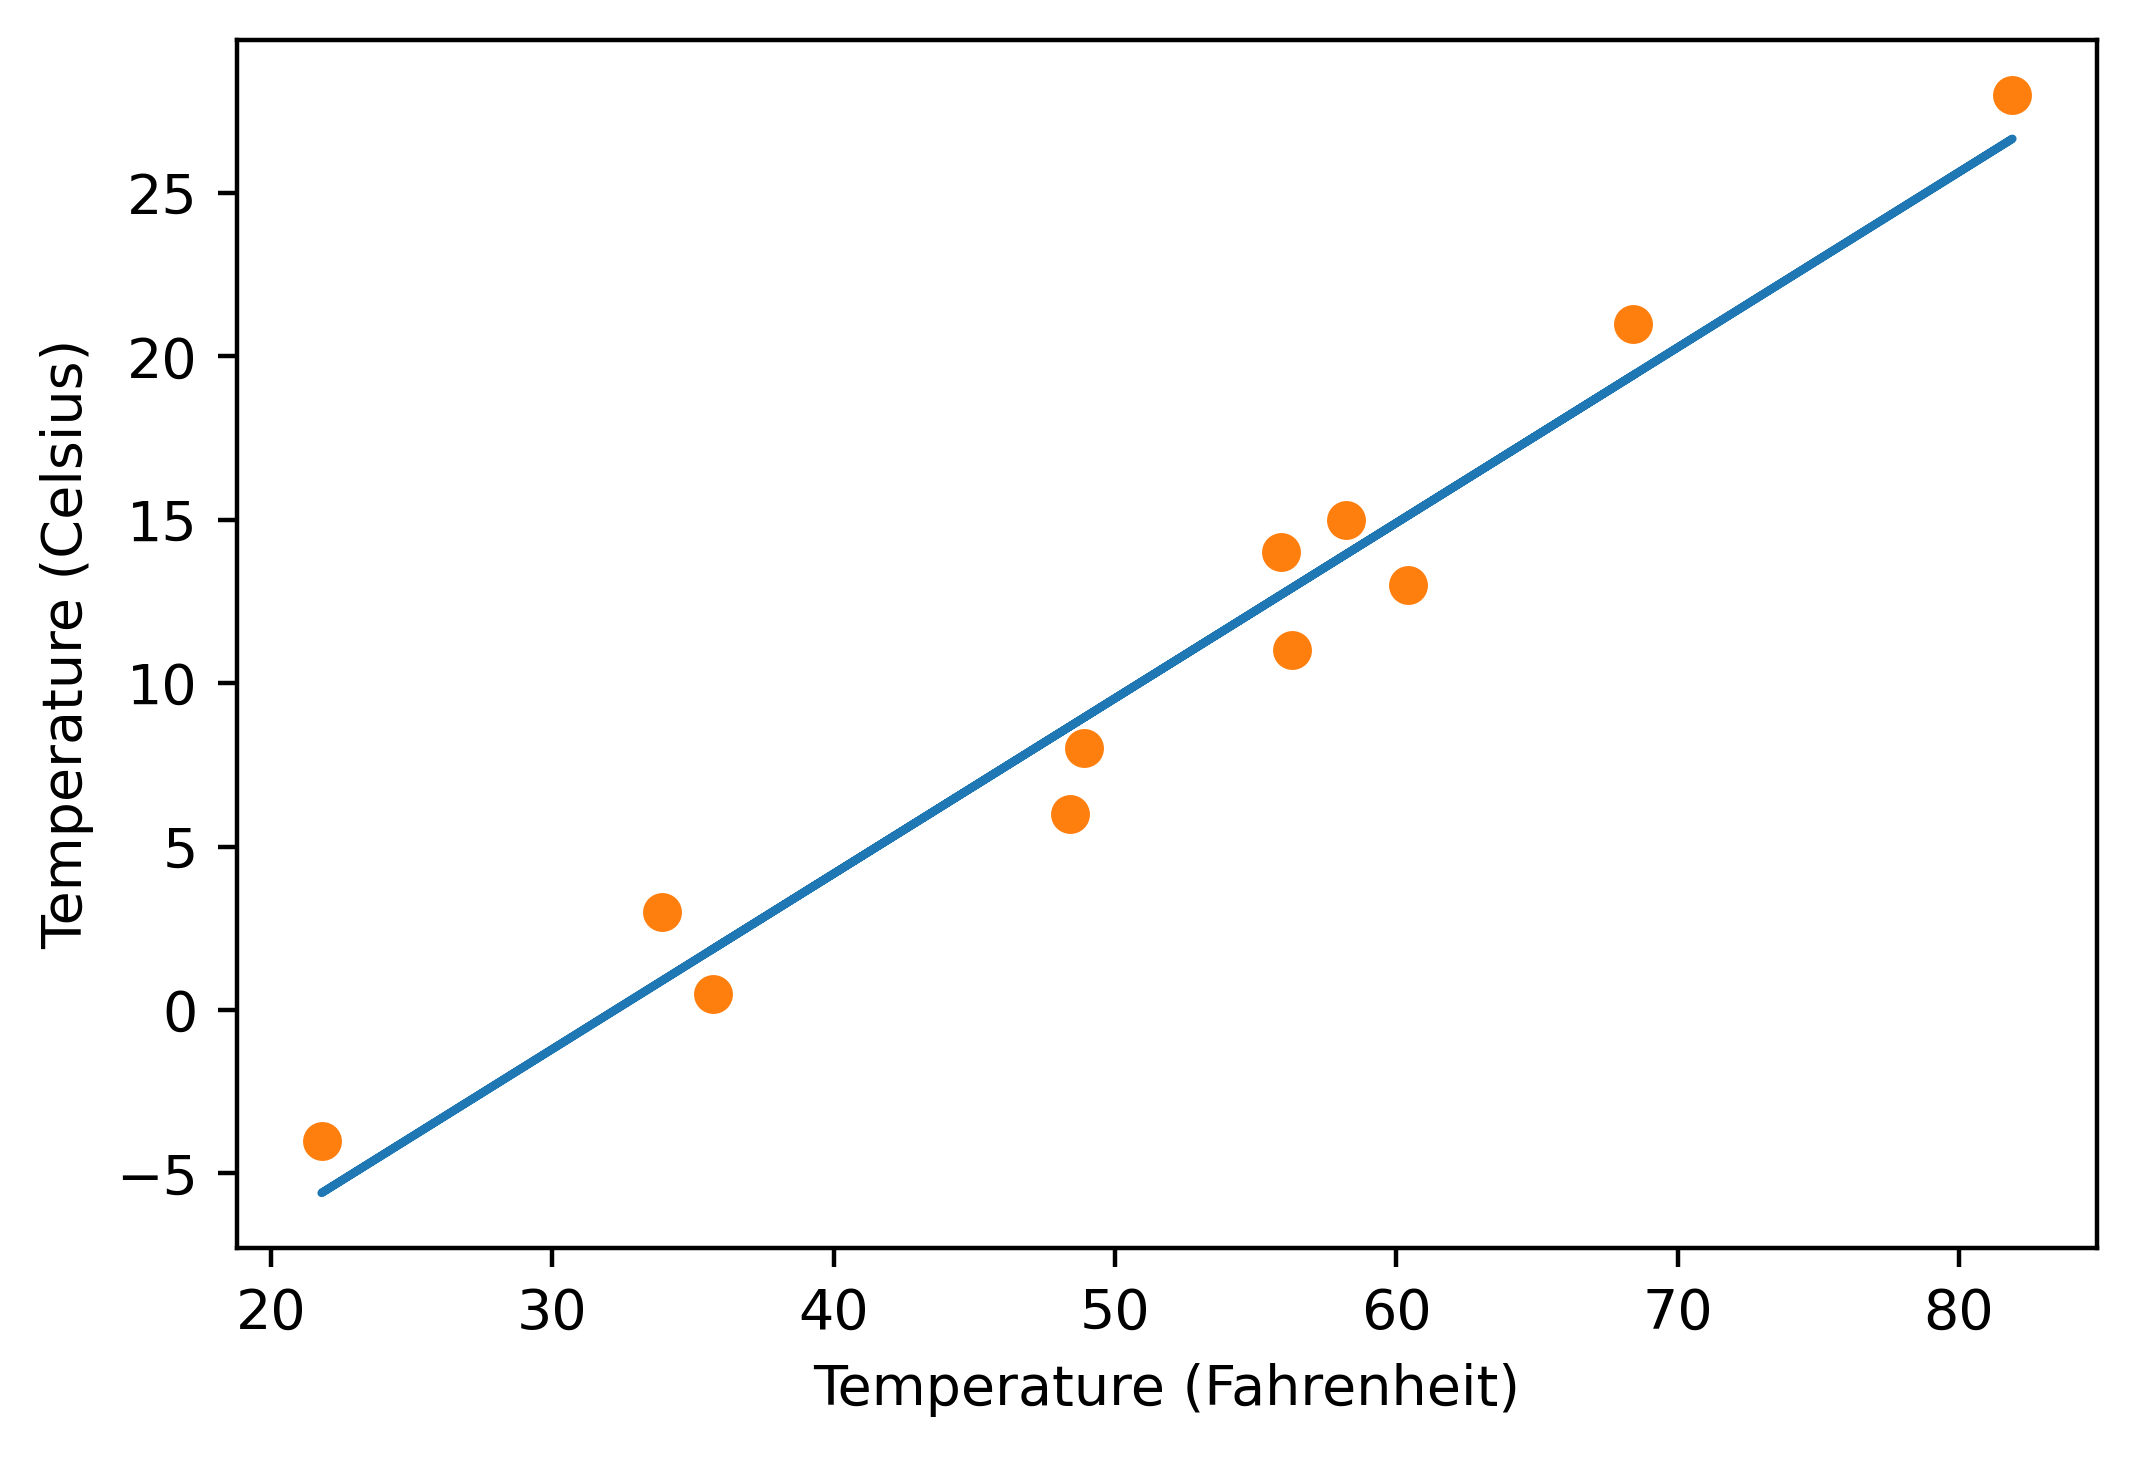

In [44]:
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

t_p = model(t_un, *params)

fig = plt.figure(dpi=400)
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Temperature (Celsius)')
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()


# Optimizer

In [45]:
import torch.optim as optim 

params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-5
optimizer = optim.SGD([params], lr=lr)

In [46]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)